# Przetwarzanie raportów resuscytacyjnych za pomocą OpenAI API

## Wstęp 
Celem niniejszej pracy jest zaprojektowanie i implementacja systemu przetwarzania szpitalnych raportów resuscytacyjnych. 

Praca skupi się na opracowaniu programu umożliwiającego efektowną i dokładną analizę przebiegu wielu interwencji naraz oraz wyciągnięciu wniosków, które mogą poprawić procedury medyczne. 

### Import danych
W pierwszej części dane w postaci pliku JSON zostają zaimportowane.

In [2]:
import json
import os

def import_data(filepath): 
  """
  Imports data from a JSON file and converts it to a string format.

  Parameters:
  filepath (str): Path to the JSON file.

  Returns:
  str: Data from the JSON file as a single string with elements separated by newlines.

  Raises:
  FileNotFoundError: If the file does not exist.
  ValueError: If the file content is not a valid JSON.
  TypeError: If the JSON content is not a list of strings.
  """
  if not os.path.exists(filepath):
      raise FileNotFoundError(f"The file '{filepath}' does not exist.")
  
  try:
      with open(filepath, 'r') as file:
          data = json.load(file)
      if not isinstance(data, list) or not all(isinstance(item, str) for item in data):
          raise TypeError("The JSON content must be a list of strings.")
      return "\n".join(data)
  
  except json.JSONDecodeError as e:
      raise ValueError(f"Failed to decode JSON: {e}")

### Podział raportów na paczki
W tej sekcji raporty zostają podzielone na paczki (batches), tak, aby zoptymalizować liczbę tokenów wysyłanych do modelu. 

Token to najmniejsza jednostka tekstu przetwarzana przez model językowy, taka jak słowo, część słowa, znak interpunkcyjny lub spacja. W przypadku uzywanego tutaj modelu GPT-4-turbo maksymalna liczba tokenów wynosi 4096, stąd zapytanie razem z raportami musi mieścić się w tym zakresie.

Instrukcja wysyłana jest do modelu razem z kolejnymi paczkami az do momentu wyczerpania paczek. 

In [40]:
import tiktoken

def split_reports_into_batches(report_list, prompt, max_tokens=4096):
    """
    Splits a list of reports into batches based on token limits, ensuring that the total token count
    (including a given prompt) does not exceed the specified maximum tokens per batch.

    Parameters:
        report_list (list of str): A list of report strings to be split into batches.
        prompt (str): The prompt text to include with each batch, which affects the token limit.
        max_tokens (int, optional): The maximum number of tokens allowed in a single batch, including the prompt, defaults to 4096.

    Returns:
        list of list of str: A list of batches, where each batch is a list of reports whose combined token count 
        (plus the prompt) stays within the maximum token limit.
    """
    tokenizer = tiktoken.get_encoding("cl100k_base")
    
    prompt_tokens = len(tokenizer.encode(prompt))
    max_tokens_per_batch = max_tokens - prompt_tokens

    batches = []
    current_batch = []
    current_tokens = 0

    for report in report_list:
        report_tokens = tokenizer.encode(report)
        report_token_count = len(report_tokens)

        if current_tokens + report_token_count > max_tokens_per_batch:
            batches.append(current_batch)
            current_batch = []
            current_tokens = 0

        current_batch.append(report)
        current_tokens += report_token_count

    if current_batch:
        batches.append(current_batch)

    return batches

### Połączenie z modelem 
Zachodzi domyślnie dla modelu GPT-4-turbo.

In [4]:
from openai import OpenAI

def get_response(prompt):
    """
    Sends a prompt to an external chat model (gpt-4-turbo) and retrieves the response.

    Parameters:
    prompt (str): The input string to be processed by the model.

    Returns:
    str: The response generated by the model.

    Raises:
    ValueError: If the prompt is empty or invalid.
    Exception: For any unexpected errors during the API call.
    """
    try:
        if not isinstance(prompt, str) or not prompt.strip():
            raise ValueError("Prompt must be a non-empty string.")
        
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            temperature=0.0,
            messages=[
                {"role": "system", "content": "Jesteś pomocnym asystentem."},
                {"role": "user", "content": prompt}
            ],
        )
        
        assistant_response = response.choices[0].message.content
        
        if not assistant_response or not isinstance(assistant_response, str):
            raise ValueError("Model response is empty or invalid.")
        
        return assistant_response.strip()

    except ValueError as ve:
        print(f"Input or response validation error: {ve}")
        raise  
        
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise 

## Przetwarzanie danych

### Prompt i przetwarzanie odpowiedzi modelu
Prompt wysyłany do modelu ma dwie funkcje. 

1. Oddzielenie raportów resuscytacyjnych od raportów jedyne wspominających o poprzedniej resucytacji (w tej sytuacji model ma zwrócić łańcuch znaków 'BRAK'). 

2. Zwrócenie przez model odpowiedzi na raport resuscytacyjny w postaci oddzielonych od siebie przecinkiem słów kluczowych (takich jak asystolia, ambu, defibrylacja, ROSC), które mają informować w jak najbardziej skróconej i gotowej do przetworzenia formie o procedurach, jakie miały miejsce podczas resuscytacji. 

Treść wszystkich raportów jest wysoce róznorodna i pojawiają się w nich takze informacje o np. problemach związanych z intubacją, chorobach współtowarzyszących pacjenta lub kilkukrotnych defibrylacjach podczas jednej resuscytacji. W promptcie skupiono się jednak na najczęściej powtarzanych procedurach, ograniczając "słownik" odpowiedzi modelu do konkretnych pojęć. 

#### Metody prompt engineering 

W powyzszej instrukcji wykorzystano następujące metody prompt engineering: 

1. **Role instruction**
("Jesteś specjalistą od analizy danych medycznych"): Pomaga skoncentrować działanie modelu na odpowiedniej dziedzinie i nadaje kontekst.

2. **Explicit instructions**
Szczegółowo opisano zadanie podziału raportów na dwie kategorie i podano wytyczne, jak postępować w przypadku kazdej z kategorii. 

3. **Constrained output**
Zdefiniowano słownik pojęć, aby zredukować ryzyko uzycia nieodpowiednich terminów. 

4. **Few-Shot Learning**
Dołączono przykłady raportów i ich odpowiedzi. 

5. **Standardized Output** 
Wymóg utrzymania standardowego formatu odpowiedzi w mianowniku (np. “czas X”, “adrenalina”).

6. **Disambiguation** 
Rozwiązano potencjalne niejasności poprzez wyjaśnienie wyjątków (np. bradyasystolia → asystolia) oraz oczekiwana reakcja na brak danych (“BRAK”) została zdefiniowana jednoznacznie.

7. **Task Prioritization**
Zadanie jest podzielone na dwa logiczne kroki:
	1.	Przyporządkowanie raportu do kategorii.
	2.	Generowanie odpowiedzi w formie słów kluczowych lub zwrócenie “BRAK”.
	

8. **Highlighting Key Points**
Uzycie pogrubienia ("**Kategoria 1**") i dodatkowych tagów (<\raporty>) ułatwiające modelowi priorytetyzację.

In [4]:
prompt_summarize = """
Jesteś specjalistą od analizy danych medycznych. Przeczytaj podane raporty (konsultacje) szpitalne i przyporządkuj kazdy do jednej z dwóch kategorii:
1. **Kategoria 1**: Konsultacja opisuje aktywną resuscytację pacjenta, obejmującą działania takie jak: podjęcie resuscytacji, intubacja, podanie leków ratunkowych (np. adrenaliny), użycie defibrylatora, wykonywanie masażu serca itp.
2. **Kategoria 2**: Konsultacja odnosi się do wcześniejszej resuscytacji, ale nie opisuje aktywnej resuscytacji w trakcie danej konsultacji (np. stan pacjenta po wcześniejszym NZK, informacje o przebytej resuscytacji bez szczegółów interwencji w obecnym czasie).

Twoje zadanie:
1. Jeśli raport należy do **Kategorii 1**, zamień raport na zestawienie w formie słów kluczowych. Słowa kluczowe mają być zapisane w mianowniku i w pełni standaryzowane. Oto słowa kluczowe, z których masz korzystać w odpowiedzi i z niczego innego:
   - **Mechanizmy**: "asystolia" (bradyasystolię tez traktuj jako asystolię), "VF" (migotanie komór), "PEA" (aktywność elektryczna bez tętna).
   - **Czas**: czas trwania resuscytacji w minutach, określony jako różnica czasu zakończenia resuscytacji i jej rozpoczęcia lub wystąpienia NZK ("czas X"). Jeśli brak informacji, pomiń parametr czasu.
   - **Procedury**: "intubacja", "lucas", "ambu", "masaż serca", "defibrylacja", podane leki: "adrenalina", "bikarbonat", "amiodaron", "inne leki".
   - **Wynik**: "ROSC", "zgon".

   Jeśli w raporcie brakuje danych, pomiń te parametry w odpowiedzi. Zachowaj standardowy format wyjściowy.

2. Jeśli raport należy do **Kategorii 2**, zwróć dokładnie tekst: 'BRAK'.

### Przykłady
**Raporty:**  
["Wezwanie na interwencję z powodu nagłego zatrzymania krążenia (NZK). Według relacji personelu SOR, zatrzymanie krążenia nastąpiło około godziny 14:30 w mechanizmie asystolii. Natychmiast rozpoczęto RK, wykonując masaż zewnętrzny serca oraz intubując pacjenta przez usta. Rozpoczęto wentylację przy pomocy worka Ambu, a masaż serca kontynuowano przy użyciu urządzenia Lucas.
W trakcie działań podano łącznie 6 mg adrenaliny. Pomimo przeprowadzonych działań resuscytacyjnych, nie uzyskano ROSC. O godzinie 15:00 stwierdzono zgon pacjenta.", "Przy przybyciu pacjent był masowany oraz wentylowany za pomocą worka Ambu. Pacjenta zaintubowano przez usta rurką 8.5. Podawano adrenalinę zgodnie z aktualnymi wytycznymi. Pomimo prowadzonej akcji resuscytacyjnej nie uzyskano ROSC. O godzinie 16:10 stwierdzono zgon chorego.", "Pacjent NN o nieznanej przeszłości chorobowej, zaniedbany higienicznie. Stan po NZK i skutecznej resuscytacji wykonanej przez ZRM. Obecnie pacjent w stanie śpiączki, wentylowany mechanicznie, hemodynamicznie stabilny na wlewie noradrenaliny. W wykonanym TK głowy wykluczono krwawienie. Zalecenia: pełne monitorowanie, kontrolne badania laboratoryjne, RTG klatki piersiowej, ewentualna decyzja o koronarografii po ocenie stanu neurologicznego."]
**Odpowiedź:**  
["asystolia, masaż serca, intubacja, ambu, lucas, adrenalina, czas 30, zgon", "masaż serca, intubacja, ambu, adrenalina, zgon", "BRAK"]
""" 

def summarize_batches(batches):
    """
    Processes batches of medical reports and combines their summarized results.

    Parameters:
    batches (list of list of str): A list of batches, where each batch is a list of medical reports.

    Returns:
    list of str: Combined list of summarized reports without leading numbers or extra quotes.
    """
    combined_summaries = []

    for batch in batches:
        try:
            batch_content = "\n\n".join(batch)
            final_prompt = prompt_summarize + f"\n\n<raporty>\n{batch_content}\n</raporty>"
            
            response = get_response(final_prompt)
            
            summaries = [item.strip() for item in response.split("\n") if item.strip()]
            
            clean_summaries = []
            for summary in summaries:
                clean_summary = summary.split(".", 1)[-1].strip()
                clean_summary = clean_summary.strip('"')
                clean_summaries.append(clean_summary)
            
            combined_summaries.extend(clean_summaries)
        
        except Exception as e:
            print(f"Error processing batch: {batch}\nError: {e}")

    return combined_summaries

### Import danych do biblioteki pandas i ich przetwarzanie

In [47]:
import pandas as pd
import ast 

# Wcześniej zapisana odpowiedź modelu w pliku 'summ_data.txt'. Plik odczytano i przekonwertowano na listę
with open('summ_data.txt', 'r', encoding='UTF-8') as file:
    data_as_string = file.read() 

data_list = ast.literal_eval(data_as_string)
data_list[0:5]

['asystolia, masaż serca, intubacja, ambu, lucas, adrenalina, czas 30, zgon',
 'BRAK',
 'asystolia, masaż serca, intubacja, ambu, adrenalina, zgon',
 'VF, masaż serca, intubacja, adrenalina, amiodaron, defibrylacja, inne leki, ROSC',
 'asystolia, masaż serca, intubacja, ambu, adrenalina, zgon']

In [48]:
df = pd.DataFrame(data_list, columns=["report"])
df                

,report
0,"asystolia, masaż serca, intubacja, ambu, lucas..."
1,BRAK
2,"asystolia, masaż serca, intubacja, ambu, adren..."
3,"VF, masaż serca, intubacja, adrenalina, amioda..."
4,"asystolia, masaż serca, intubacja, ambu, adren..."
...,...
331,"PEA, masaż serca, intubacja, lucas, adrenalina..."
332,"masaż serca, intubacja, ambu, lucas, adrenalin..."
333,"masaż serca, intubacja, adrenalina, zgon"
334,"asystolia, masaż serca, adrenalina, czas 20, zgon"


In [50]:
# Pozbycie się konsultacji wspominających o przeszłej resuscytacji ('BRAK')
df = df[df['report'] != 'BRAK']

df.reset_index(drop=True, inplace=True)

def process_report(report):
    """
    Processes a single medical report to extract key components.

    This function identifies and categorizes elements from a medical report string into 
    the following categories:
    - Mechanisms (e.g., "asystolia", "VF", "PEA")
    - Procedures (e.g., "intubacja", "lucas", "ambu", etc.)
    - Results (e.g., "ROSC", "zgon")
    - Time (e.g., "czas X", including ranges like "czas 20-30", where the average is calculated)

    Parameters:
        report (str): The input report string containing comma-separated elements.

    Returns:
        dict: A dictionary containing the following keys:
            - "mechanisms": A sorted list of mechanisms present in the report, or None if absent.
            - "procedures": A sorted list of procedures identified in the report.
            - "result": A sorted list of results (e.g., "ROSC", "zgon"), or None if absent.
            - "time": The extracted time as a numeric value (or average for ranges), or None if unavailable.
    """
    # Kategorie
    mechanisms = {"asystolia", "VF", "PEA"}
    procedures = {"intubacja", "lucas", "ambu", "masaż serca", "defibrylacja",
                  "adrenalina", "bikarbonat", "amiodaron", "inne leki"}
    results = {"ROSC", "zgon"}
    
    # Parsowanie raportu
    elements = set(report.split(", "))
    mech = sorted(list(elements & mechanisms))  # Posegregowane mechanizmy
    proc = sorted(list(elements & procedures))  # Wszystkie procedury
    result = sorted(list(elements & results))  # Wynik 
    
    # Znalezienie czasu
    time = [el for el in elements if el.startswith("czas")]
    
    # Obsługa czasu
    extracted_time = None
    if time:
        try:
            time_value = time[0].split()[1]
            if "-" in time_value:  # Obsługa zakresów czasu (np. "czas 20-30")
                lower, upper = map(int, time_value.split("-"))
                extracted_time = (lower + upper) / 2  # Średnia z zakresu
            else:
                extracted_time = int(time_value)  
        except ValueError:
            extracted_time = None  # Jeśli nie jest liczbą ("czas X"), ustaw na None
    
    return {
        "mechanisms": mech if mech else None,  
        "procedures": proc,                    
        "result": result if result else None,  
        "time": extracted_time               
    }

processed_data = df["report"].apply(process_report)

df_processed = pd.DataFrame(processed_data.tolist())
df_processed

,mechanisms,procedures,result,time
0,[asystolia],"[adrenalina, ambu, intubacja, lucas, masaż serca]",[zgon],30.0
1,[asystolia],"[adrenalina, ambu, intubacja, masaż serca]",[zgon],NaN
2,[VF],"[adrenalina, amiodaron, defibrylacja, inne lek...",[ROSC],NaN
3,[asystolia],"[adrenalina, ambu, intubacja, masaż serca]",[zgon],NaN
4,[asystolia],"[adrenalina, bikarbonat, inne leki, intubacja,...",[ROSC],8.0
...,...,...,...,...
266,[asystolia],[intubacja],[zgon],NaN
267,[PEA],"[adrenalina, intubacja, lucas, masaż serca]",[zgon],NaN
268,None,"[adrenalina, ambu, intubacja, lucas, masaż serca]",[ROSC],10.0
269,None,"[adrenalina, intubacja, masaż serca]",[zgon],NaN


#### Mechanizmy
Informacje ekstrahowane z  mechanizmów NZK (asystolia, VF, PEA) to:
1. **Liczba wystąpień** każdego mechanizmu.
2. **Częstość współwystępowania** mechanizmów w jednym raporcie.
3. **Proporcja** każdego mechanizmu względem całości raportów.

Na podstawie proporcji mechanizmów utworzono wykres kołowy umieszczany w raporcie podsumowującym. W wykresie skupiono się na przypadkach mechanizmów występujących pojedynczo.

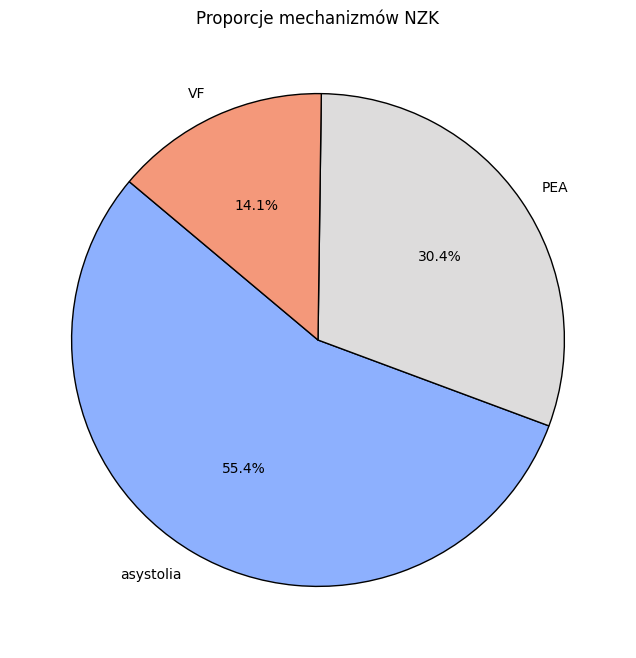

Mechanizmy i ich wystąpienia
   Mechanizm  Wystąpienia  Proporcja [%]
0  asystolia          173          63.84
1        PEA           95          35.06
2         VF           44          16.24

Współwystępowania mechanizmów
        Mechanizmy  Wystąpienia
0  PEA + asystolia           30
1   VF + asystolia           20
2         PEA + VF            8

Słownik wyników (do dokumentu podsumowującego):
{'mechanisms': [{'name': 'asystolia', 'count': 173, 'proportion': 63.84}, {'name': 'VF', 'count': 44, 'proportion': 16.24}, {'name': 'PEA', 'count': 95, 'proportion': 35.06}, {'name': 'VF + asystolia', 'count': 20, 'proportion': None}, {'name': 'PEA + VF', 'count': 8, 'proportion': None}, {'name': 'PEA + asystolia', 'count': 30, 'proportion': None}]}


In [95]:
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Zamiana wartości NaN na puste listy
df_processed["mechanisms"] = df_processed["mechanisms"].apply(lambda x: x if isinstance(x, list) else [])

total_reports = len(df_processed)

# Liczba wystąpień każdego mechanizmu
mechanism_counts = Counter([mech for mechs in df_processed["mechanisms"] for mech in mechs])

# Proporcja mechanizmów
mechanism_proportions = {
    key: round((count / total_reports) * 100, 2) for key, count in mechanism_counts.items()
}

# Tworzenie df mechanizmów
mechanisms_df = pd.DataFrame([
    {"Mechanizm": mech, "Wystąpienia": count, "Proporcja [%]": mechanism_proportions[mech]}
    for mech, count in mechanism_counts.items()
]).sort_values(by="Wystąpienia", ascending=False).reset_index(drop=True)

# Współwystępowania mechanizmów
co_occurrence_counts = Counter()
for mechs in df_processed["mechanisms"]:
    co_occurrence_counts.update(combinations(sorted(mechs), 2))

# Tworzenie df współwystąpień
cooccurrences_df = pd.DataFrame([
    {"Mechanizmy": f"{pair[0]} + {pair[1]}", "Wystąpienia": count}
    for pair, count in co_occurrence_counts.items()
]).sort_values(by="Wystąpienia", ascending=False).reset_index(drop=True)

# Słownik wyników
results_mech = {
    "mechanisms": [
        {"name": mech, "count": count, "proportion": mechanism_proportions[mech]}
        for mech, count in mechanism_counts.items()
    ] + [
        {"name": f"{pair[0]} + {pair[1]}", "count": count, "proportion": None}
        for pair, count in co_occurrence_counts.items()
    ],
}

# Wykres kołowy dla proporcji mechanizmów NZK
plt.figure(figsize=(8, 8))
colors = sns.color_palette("coolwarm", len(mechanisms_df))
plt.pie(
    mechanisms_df["Proporcja [%]"],
    labels=mechanisms_df["Mechanizm"],
    autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "black"},
)
plt.savefig("proporcje_mechanizmow.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Wyświetlenie wyników
print("Mechanizmy i ich wystąpienia")
print(mechanisms_df)
print("\nWspółwystępowania mechanizmów")
print(cooccurrences_df)
print("\nSłownik wyników (do dokumentu podsumowującego):")
print(results_mech)

#### Czas trwania resuscytacji 
Informacje istotne to: 
1. **Najkrótszy czas** resuscytacji.
2. **Najdłuższy czas** resuscytacji.
3. **Średni czas** resuscytacji.
4. **Mediana czasu** resuscytacji.
5. **Odchylenie standardowe czasu** resuscytacji (zmienność w czasie trwania).
6. **Ilość raportów** zawierających brak danych na temat czasu.

In [99]:
if "time" in df_processed.columns:
    df.loc[:, "time"] = pd.to_numeric(df_processed["time"], errors="coerce")
else:
    raise ValueError("The 'time' column does not exist in the DataFrame.")

# Statystyki
min_time = float(df["time"].min())
max_time = float(df["time"].max())
mean_time = float(df["time"].mean())
median_time = float(df["time"].median())
std_time = float(df["time"].std())
missing_time_percentage = float((df["time"].isna().sum() / total_reports) * 100)

# Do dokumentu podsumowującego
time_stats = {
    "min_time": min_time,
    "max_time": max_time,
    "mean_time": mean_time,
    "median_time": median_time,
    "std_time": std_time,
    "missing_time_percentage": missing_time_percentage,
}

time_stats_df = pd.DataFrame(list(time_stats.items()), columns=["Metryka", "Wartość"])

print("Statystyki czasu:")
print(time_stats)

Statystyki czasu:
{'min_time': 1.0, 'max_time': 288.0, 'mean_time': 33.72592592592593, 'median_time': 25.0, 'std_time': 31.8362014979075, 'missing_time_percentage': 50.184501845018445}


#### Procedury 
Procedury podzielono dodatkowo na trzy kategorie: 
- Urządzenia: Ambu, Lucas
- Leki: adrenalina, bikarbonar, amiodaron, inne leki
- Metody (RKO): masaz serca, intubacja, defibrylacja, wentylacja

Informacje istotne to:
1. **Liczba wystąpień** każdej procedury.
2. **Proporcja wykorzystania** poszczególnych procedur (np. jaki procent raportów zawiera intubację?).
3. **Współwystępowanie procedur** w jednym raporcie (np. intubacja + lucas + adrenalina).
4. **Zależności między procedurami** i wynikami (np. jaki procent raportów z ROSC zawierał defibrylację?).

Dodatkowo wygenerowano wykres słupkowy przedstawiający wystąpienia poszczególnych procedur, który umieszczany zostaje w raporcie podsumowującym.

Tabela podsumowująca wszystkie procedury i ich proporcje do wszystkich raportów:
    Kategoria     Procedura  Wystąpienia  Proporcja [%]  ROSC [%]  Zgony [%]
0        Leki    adrenalina          176          64.94     42.05      59.09
1        Leki     inne leki           48          17.71     41.67      60.42
2        Leki    bikarbonat           37          13.65     40.54      59.46
3        Leki     amiodaron           12           4.43     75.00      25.00
4    Metodyka     intubacja          247          91.14     40.89      60.73
5    Metodyka   masaż serca          227          83.76     38.33      62.56
9    Metodyka    wentylacja           90          33.21     43.33      57.78
6    Metodyka  defibrylacja           49          18.08     57.14      42.86
7  Urządzenia          ambu           90          33.21     43.33      57.78
8  Urządzenia         lucas           61          22.51     31.15      68.85

Trzy najczęstsze współwystępowania metod RKO:
               cooccurren

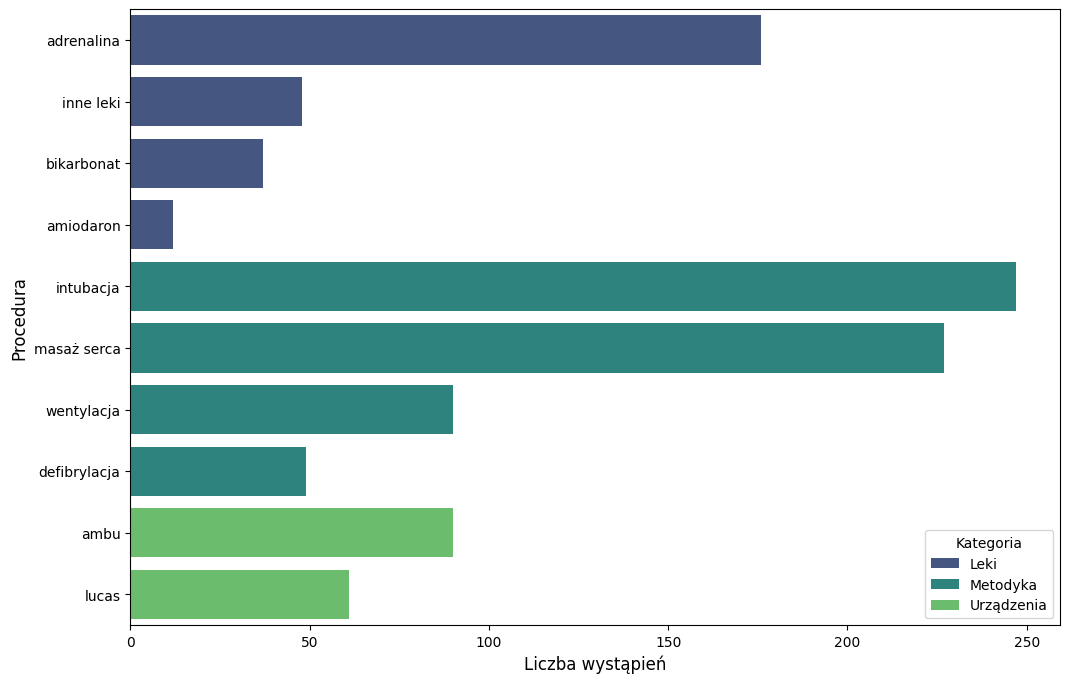

{'procedures': [{'Kategoria': 'Leki',
   'Procedura': 'adrenalina',
   'Wystąpienia': 176,
   'Proporcja [%]': 64.94,
   'ROSC [%]': 42.05,
   'Zgony [%]': 59.09},
  {'Kategoria': 'Leki',
   'Procedura': 'inne leki',
   'Wystąpienia': 48,
   'Proporcja [%]': 17.71,
   'ROSC [%]': 41.67,
   'Zgony [%]': 60.42},
  {'Kategoria': 'Leki',
   'Procedura': 'bikarbonat',
   'Wystąpienia': 37,
   'Proporcja [%]': 13.65,
   'ROSC [%]': 40.54,
   'Zgony [%]': 59.46},
  {'Kategoria': 'Leki',
   'Procedura': 'amiodaron',
   'Wystąpienia': 12,
   'Proporcja [%]': 4.43,
   'ROSC [%]': 75.0,
   'Zgony [%]': 25.0},
  {'Kategoria': 'Metodyka',
   'Procedura': 'intubacja',
   'Wystąpienia': 247,
   'Proporcja [%]': 91.14,
   'ROSC [%]': 40.89,
   'Zgony [%]': 60.73},
  {'Kategoria': 'Metodyka',
   'Procedura': 'masaż serca',
   'Wystąpienia': 227,
   'Proporcja [%]': 83.76,
   'ROSC [%]': 38.33,
   'Zgony [%]': 62.56},
  {'Kategoria': 'Metodyka',
   'Procedura': 'wentylacja',
   'Wystąpienia': 90,
   'Pr

In [103]:
if "procedures" in df_processed.columns:
    df_processed.loc[:, "procedures"] = df_processed["procedures"].apply(
        lambda x: x if isinstance(x, list) else []
    )
else:
    raise ValueError("The 'procedures' column does not exist in the DataFrame.")

# Kategorie klasyfikacji
categories = {
    "Leki": {"adrenalina", "bikarbonat", "amiodaron", "inne leki"},
    "Urządzenia": {"lucas", "ambu"},
    "Metodyka": {"masaż serca", "intubacja", "defibrylacja", "wentylacja"},
}

def classify_procedures(procedures):
    meds = [proc for proc in procedures if proc in categories["Leki"]]
    devs = [proc for proc in procedures if proc in categories["Urządzenia"]]
    meth = [proc for proc in procedures if proc in categories["Metodyka"]]
    
    # Jeśli występuje "ambu", dodajemy "wentylacja"
    if "ambu" in procedures and "wentylacja" not in meth:
        meth.append("wentylacja")
    
    return meds, devs, meth

# Aktualizacja kolumn procedur
df_processed[["medications", "devices", "methodology"]] = df_processed["procedures"].apply(
    lambda procs: pd.Series(classify_procedures(procs))
)

# Zliczanie wystąpień procedur
procedure_counts = Counter(proc for procs in df_processed["procedures"] for proc in procs)

# Tworzenie danych dla każdej procedury
procedure_data = []
for procedure, count in procedure_counts.items():
    category = next((cat for cat, items in categories.items() if procedure in items), None)
    subset = df_processed[df_processed["procedures"].apply(lambda procs: procedure in procs)]
    rosc_count = subset["result"].apply(lambda results: "ROSC" in results).sum()
    zgon_count = subset["result"].apply(lambda results: "zgon" in results).sum()
    total = len(subset)
    rosc_percentage = (rosc_count / total) * 100 if total > 0 else 0
    zgon_percentage = (zgon_count / total) * 100 if total > 0 else 0
    procedure_data.append({
        "Kategoria": category,
        "Procedura": procedure,
        "Wystąpienia": count,
        "Proporcja [%]": round((count / total_reports) * 100, 2),
        "ROSC [%]": round(rosc_percentage, 2),
        "Zgony [%]": round(zgon_percentage, 2),
    })

summary_df = pd.DataFrame(procedure_data).sort_values(
    by=["Kategoria", "Wystąpienia"], ascending=[True, False]
)

# Dodanie "wentylacja" na podstawie "ambu"
ambu_row = summary_df[(summary_df["Kategoria"] == "Urządzenia") & (summary_df["Procedura"] == "ambu")].iloc[0]
ventilation_row = ambu_row.copy()
ventilation_row["Kategoria"] = "Metodyka"
ventilation_row["Procedura"] = "wentylacja"
summary_df = pd.concat([summary_df, pd.DataFrame([ventilation_row])], ignore_index=True)

# Sortowanie danych przed generowaniem wykresu
summary_df["Kategoria"] = pd.Categorical(
    summary_df["Kategoria"],
    categories=["Leki", "Metodyka", "Urządzenia"],
    ordered=True
)
summary_df = summary_df.sort_values(by=["Kategoria", "Wystąpienia"], ascending=[True, False])

# Zliczanie współwystąpień w kategorii "metody"
methodology_cooccurrences = Counter()
for meths in df_processed["methodology"]:
    if isinstance(meths, list):
        methodology_cooccurrences.update(combinations(sorted(meths), 2))

# Przygotowanie danych dla top 3 współwystąpień
top_3_methodology_cooccurrences = []
for pair, count in methodology_cooccurrences.most_common(3):
    subset = df_processed[df_processed["methodology"].apply(
        lambda meths: set(pair).issubset(meths) if isinstance(meths, list) else False
    )]
    rosc_count = subset["result"].apply(lambda results: "ROSC" in results).sum()
    zgon_count = subset["result"].apply(lambda results: "zgon" in results).sum()
    total = len(subset)
    rosc_percentage = (rosc_count / total) * 100 if total > 0 else 0
    zgon_percentage = (zgon_count / total) * 100 if total > 0 else 0
    proportion = (count / total_reports) * 100 if total_reports > 0 else 0
    top_3_methodology_cooccurrences.append({
        "cooccurrence": " + ".join(pair),
        "count": count,
        "Proporcja [%]": round(proportion, 2),
        "ROSC [%]": float(round(rosc_percentage, 2)),
        "Zgony [%]": float(round(zgon_percentage, 2)),
    })

top_3_methodology_cooccurrences_df = pd.DataFrame(top_3_methodology_cooccurrences)

# Słownik wyników
results_procedures = {
    "procedures": summary_df.to_dict(orient="records"),
    "top_3_cooccurrences": top_3_methodology_cooccurrences,
}

# Wyniki
print("Tabela podsumowująca wszystkie procedury i ich proporcje do wszystkich raportów:")
print(summary_df)
print("\nTrzy najczęstsze współwystępowania metod RKO:")
print(top_3_methodology_cooccurrences_df)

# Wykres słupkowy podsumowujący procedury 
plt.figure(figsize=(12, 8))
sns.barplot(
    data=summary_df, 
    x="Wystąpienia", 
    y="Procedura", 
    hue="Kategoria", 
    palette="viridis"
)

# Dodanie szczegółów do wykresu
plt.xlabel("Liczba wystąpień", fontsize=12)
plt.ylabel("Procedura", fontsize=12)
plt.legend(title="Kategoria", fontsize=10, loc="lower right")

# Zapisanie wykresu
output_path = "wykres_procedury.png"  
plt.savefig(output_path, format="png", dpi=300, bbox_inches="tight")

# Wyświetlenie wykresu
plt.show()
results_procedures

#### Wyniki resuscytacji
Istotne dane:

1. **Liczba raportów** z ROSC i liczba raportów zgonów.
2. **Proporcja ROSC do zgonów**.
3. **Zależność wyniku** od mechanizmów (np. ROSC w raportach z VF vs. asystolią).
4. **Zależność wyniku** od czasu trwania resuscytacji (np. jaka była średnia długość resuscytacji dla raportów z ROSC?).

In [89]:
df_processed["result"] = df_processed["result"].apply(lambda x: x if isinstance(x, list) else [])

# Generowanie tablicy wynikowej
result_counts = df_processed["result"].explode().value_counts()
total_reports = len(df_processed)

result_summary = pd.DataFrame({
    "Wynik": result_counts.index,
    "Liczba raportów": result_counts.values,
    "Proporcja [%]": (result_counts.values / total_reports) * 100
}).reset_index(drop=True)

# Generowanie tablicy zaleznosci wyniku od mechanizmów NZK
mechanisms = ["asystolia", "VF", "PEA"]
mechanism_dependency_data = []

for mechanism in mechanisms:
    subset = df_processed[df_processed["mechanisms"].apply(lambda mechs: mechanism in mechs if isinstance(mechs, list) else False)]
    
    rosc_count = subset["result"].apply(lambda results: "ROSC" in results).sum()
    zgon_count = subset["result"].apply(lambda results: "zgon" in results).sum()
    
    total = len(subset)
    avg_time = subset["time"].mean() if total > 0 else np.nan
    
    mechanism_dependency_data.append({
        "Mechanizm": mechanism,
        "Procent ROSC (%)": (rosc_count / total) * 100 if total > 0 else 0,
        "Procent zgonów (%)": (zgon_count / total) * 100 if total > 0 else 0,
        "Średni czas [min]": avg_time
    })

mechanism_dependency_df = pd.DataFrame(mechanism_dependency_data)

# Tworzenie słownika dla wyników resuscytacji do dokumentu podsumowującego 
results_resuscitation = {
    "results_summary": [
        {
            "result": row["Wynik"],
            "count": row["Liczba raportów"],
            "proportion": round(row["Proporcja [%]"], 2),
        }
        for _, row in result_summary.iterrows()
    ],
    "mechanism_dependency": [
        {
            "mechanism": row["Mechanizm"],
            "rosc_percentage": round(row["Procent ROSC (%)"], 2),
            "zgon_percentage": round(row["Procent zgonów (%)"], 2),
            "avg_time": round(row["Średni czas [min]"], 2) if not pd.isna(row["Średni czas [min]"]) else None,
        }
        for _, row in mechanism_dependency_df.iterrows()
    ],
}

# Wyniki
print("Wyniki resuscytacji w raportach:")
print(result_summary)

print("\nZaleznosc wyniku od mechanizmu NZK:")
print(mechanism_dependency_df)
results_resuscitation

Wyniki resuscytacji w raportach:
  Wynik  Liczba raportów  Proporcja [%]
0  zgon              163      60.147601
1  ROSC              112      41.328413

Zaleznosc wyniku od mechanizmu NZK:
   Mechanizm  Procent ROSC (%)  Procent zgonów (%)  Średni czas [min]
0  asystolia         35.838150           65.317919          32.137931
1         VF         61.363636           38.636364          50.722222
2        PEA         36.842105           65.263158          37.351852


{'results_summary': [{'result': 'zgon', 'count': 163, 'proportion': 60.15},
  {'result': 'ROSC', 'count': 112, 'proportion': 41.33}],
 'mechanism_dependency': [{'mechanism': 'asystolia',
   'rosc_percentage': 35.84,
   'zgon_percentage': 65.32,
   'avg_time': 32.14},
  {'mechanism': 'VF',
   'rosc_percentage': 61.36,
   'zgon_percentage': 38.64,
   'avg_time': 50.72},
  {'mechanism': 'PEA',
   'rosc_percentage': 36.84,
   'zgon_percentage': 65.26,
   'avg_time': 37.35}]}

### Generowanie dokumentu podsumowującego

In [97]:
# Tworzenie słownika podsumowującego do dokumentu
data_summary = {
    "total reports": total_reports,
    "results_mech": results_mech,
    "time_stats": time_stats,
    "result_procedures": results_procedures,
    "results_resuscitation": results_resuscitation,
}

data_summary

{'total reports': 271,
 'results_mech': {'mechanisms': [{'name': 'asystolia',
    'count': 173,
    'proportion': 63.84},
   {'name': 'VF', 'count': 44, 'proportion': 16.24},
   {'name': 'PEA', 'count': 95, 'proportion': 35.06},
   {'name': 'VF + asystolia', 'count': 20, 'proportion': None},
   {'name': 'PEA + VF', 'count': 8, 'proportion': None},
   {'name': 'PEA + asystolia', 'count': 30, 'proportion': None}]},
 'time_stats': {'min_time': np.float64(1.0),
  'max_time': np.float64(288.0),
  'mean_time': np.float64(33.72592592592593),
  'median_time': np.float64(25.0),
  'std_time': np.float64(31.8362014979075),
  'missing_time_percentage': np.float64(50.184501845018445)},
 'result_procedures': {'procedures': [{'category': 'Leki',
    'name': 'adrenalina',
    'count': 176,
    'proportion': 64.94,
    'rosc': 42.05,
    'zgon': 59.09},
   {'category': 'Leki',
    'name': 'inne leki',
    'count': 48,
    'proportion': 17.71,
    'rosc': 41.67,
    'zgon': 60.42},
   {'category': 'Leki

In [ ]:
from jinja2 import Template

# Load the LaTeX template
template_path = "report_template.tex"
with open(template_path, "r") as file:
    template = Template(file.read())

# Render the template with data
rendered_tex = template.render(data=data)

# Save the rendered LaTeX file
output_tex_path = "report_generated.tex"
with open(output_tex_path, "w") as file:
    file.write(rendered_tex)

# Compile the LaTeX file into a PDF
output_pdf_path = "report_generated.pdf"
os.system(f"pdflatex -interaction=nonstopmode -output-directory={os.getcwd()} {output_tex_path}")

# Clean up auxiliary files generated by LaTeX
auxiliary_extensions = [".aux", ".log", ".out"]
for ext in auxiliary_extensions:
    try:
        os.remove(f"report_generated{ext}")
    except FileNotFoundError:
        pass

In [33]:
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=key)
filepath = os.getenv("filepath")